In [1]:
#On spécifie le chemin d'accès des fichiers : train et test100
train_dir = "../input/dogs-vs-cats/train.zip"
test_dir = "../input/test100/test100"

In [2]:
# On Importe le module zipfile qui permet de manipuler des fichiers ZIP.
import zipfile

#On extrait notre fichier zip train:
with zipfile.ZipFile(train_dir,'r') as z:
    z.extractall()

#Après l'extraction des données, on obtient un dossier stocké dans l'output.

In [3]:
#on importe le module os qui permet d'intéragir avec le système d'exploitation
import os

#On crée une liste "images" qui contient le nom de tous les fichiers dans le dossier "train"
images = os.listdir("./train")

#On crée une liste "test_images" qui contient le nom de tous les fichiers dans le dossier "test100"
test_images = os.listdir(test_dir)

#On importe la bibliothèque pandas permettant la manipulation et l'analyse des données.
import pandas as pd

#On utilise la fonction DataFrame() qui organise les données en lignes et en colonnes:
data = pd.DataFrame(images)
test_data = pd.DataFrame(test_images)

#On change le nom de la colonne pour data et test data de "0" à, respectivement, "image" et "test image":
data = data.rename(columns = {0:'image'})
test_data = test_data.rename(columns = {0: 'test image'})

#On ajoute le chemin d'accès avant le nom de chaque element dans chaque colonne de nos deux données:
data['image'] = data['image'].apply(lambda x: './train/' + x)
test_data['test image']= test_data['test image'].apply(lambda x: test_dir + "/"+ x)

#Notons que la colonne "image"/"test image" contient le chemin d'accès de chaque image !

#On crée une nouvelle variable "label" qui prend les valeurs "dog" ou "cat" selon x:
data['label'] = data['image'].apply(lambda x: 'cat' if 'cat' in x else 'dog')
test_data['label'] = test_data['test image'].apply(lambda x: 'cat' if 'cat' in x else 'dog')

#On observe les 5 premières lignes de notre data:
display(data.head())
display(test_data.head())

,image,label
0,./train/dog.8154.jpg,dog
1,./train/cat.10618.jpg,cat
2,./train/dog.7678.jpg,dog
3,./train/cat.11192.jpg,cat
4,./train/dog.11191.jpg,dog


,test image,label
0,../input/test100/test100/dog.83.jpg,dog
1,../input/test100/test100/dog.1.jpg,dog
2,../input/test100/test100/cat.14.jpg,cat
3,../input/test100/test100/dog.74.jpg,dog
4,../input/test100/test100/cat.22.jpg,cat


In [4]:
# Data contient 25000 observations (lignes) et 2 variables (colonnes)
display(data.shape)

# Test data contient 100 observations (lignes) et 2 variables (colonnes)
display(test_data.shape)

(25000, 2)

(100, 2)

In [5]:
#On scinde notre data en deux sous-ensembles de données:

#Données d'entraînement : 80% de lignes (20000) et 2 colonnes
train_data = data.iloc[0:20000, 0:2]
print(train_data.shape)

#Données de validation: 20% de lignes (5000) et 2 colonnes
validation_data = data.iloc[20000:25000, 0:2]
print(validation_data.shape)

(20000, 2)
(5000, 2)


In [6]:
# On importe le module ImageDataGenerator qui génère des lots de données d'images tensorielles avec une augmentation des données en temps réel.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
#Comme 255 est la valeur maximale d'un pixel, on change l'echelle de ces valeurs en divisant par 255 afin qu'elles prennent de nouvelles valeurs allant de 0 à 1.
train_datagen =  ImageDataGenerator(rescale=1/255)
validation_datagen =  ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

In [8]:
#Transformer nos dataframes en batches d'images uniformisées:

train_genarator = train_datagen.flow_from_dataframe(train_data, target_size=(150,150),
                                                    x_col='image',y_col='label',class_mode='binary',batch_size = 32)

validation_genarator = validation_datagen.flow_from_dataframe(validation_data,target_size=(150,150),
                                                         x_col='image',y_col='label',class_mode='binary',batch_size= 32)

test_generator = test_datagen.flow_from_dataframe(test_data,target_size=(150,150),
                                                        x_col='test image',y_col='label',class_mode='binary',batch_size= 32)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [9]:
#Importer tous les bibliothèques et les modules nécéssaire à la construction de notre modèle:

import tensorflow as tf 

from tensorflow import keras

from keras.models import Sequential

from keras.models import load_model

from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

from keras import optimizers

from tensorflow.keras import regularizers

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

In [10]:
#On spécifie un modèle sequentiel : empilement simple de couches où chaque couche a exactement un tenseur d'entrée et un de sortie
model = Sequential()

#On définit quatres couches de convolution, chacune suivie d'une couche de maxpooling de dimension 2x2

#La première couche contient 32 filtres, de dimension 3x3 et avec la fonction d'activation "relu". 
#Notons qu'elle prenne des élements d'entrée de dimension 150x150x3 !
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))

#En passant à la deuxième couche, on a augmenté le nombre des filtres à 64.
model.add(Conv2D(filters=64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))

#Et finalement, les deux dernières couches contiennent 128 filtres chacune. 
model.add(Conv2D(filters=128, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))

#On utilise la fonction Flatten pour applatir les tenseurs d'entrée multidimensionnels en une seule dimension.
model.add(Flatten())

#La couche Dense transforme la matrice d'entrée en vecteur ligne, elle performe aussi des opérations de simplification.
model.add(Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))

#La couche Dropout donne de manière aléatoire la valeur 0 aux elements d'entrée avec une fréquence de 0.25 à chaque étape pendant la durée de l'entrainement.
model.add(Dropout(0.25))

#Cette couche dense génère un seul nombre et utilise la fonction d'activation "sigmoid".
model.add(Dense(1, activation='sigmoid'))

2022-10-22 12:52:45.794106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 12:52:45.917699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 12:52:45.918757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 12:52:45.920838: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

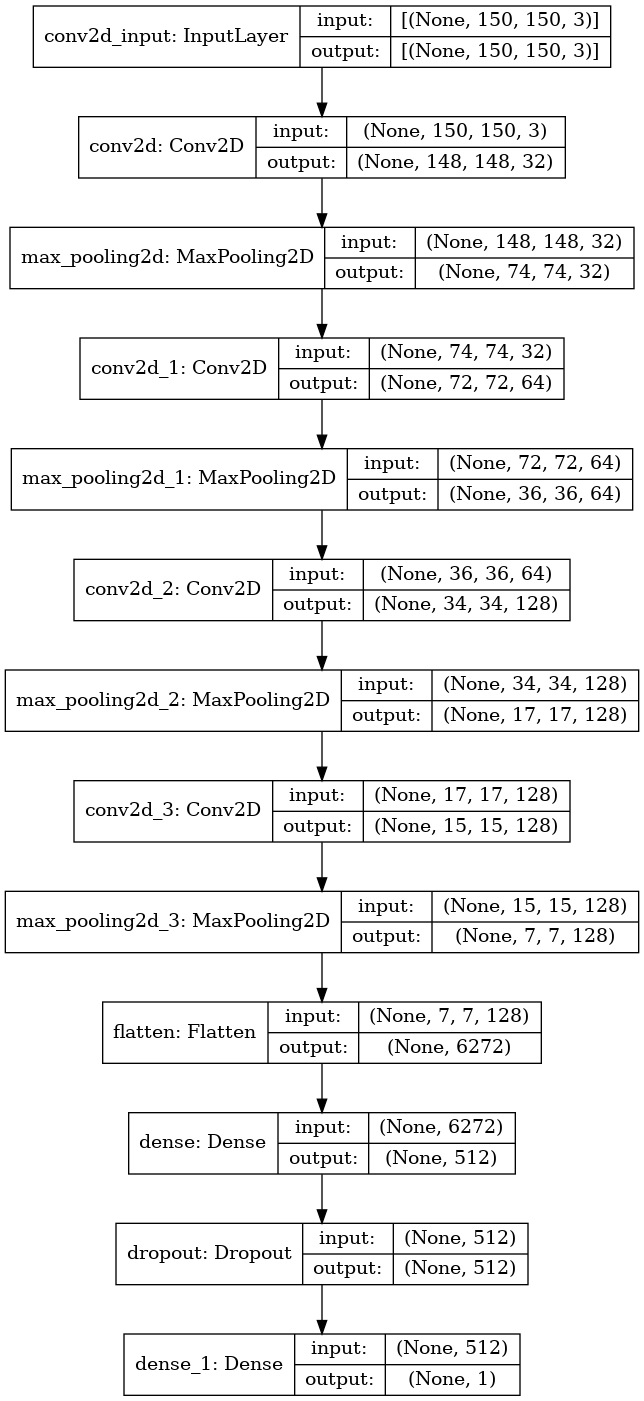

In [11]:
#Un aperçu syntéthique de notre modèle et ses couches:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [12]:
#On utilise l'optimisateur Adam avec un pas d'apprentissage de 0.001: 
opt = keras.optimizers.Adam(learning_rate=0.001)

#On configure le modèle pour l'entrainement: la fontion loss, l'optimisateur et la fonction metrics permettant d'évaluer le modèle.
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [13]:
#Un résumé utile du modèle, qui comprend : Le nom et le type de toutes les couches du modèle. Forme de sortie pour chaque couche.
model.summary()
#On remarque une réduction de l'image (dimension de la matrice) et augmentation de la profondeur de la matrice.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [14]:
#Pour libérer de la mémoire et accélérer le processus:
import gc
gc.collect()

4671

In [15]:
#On spécifie la mesure de performance à monitorer, le déclencheur, et une fois déclenché, il arrêtera le processus d'entrainement.

#Aussi, On réduit le pas d'apprentissage lorsqu'une métrique a cessé de s'améliorer.
cb = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=5, 
                                              restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss' , patience=3)]

#Une fois le modèle spécifié, on commence l'entrainement avec 100 époque:
history = model.fit(train_genarator, epochs =100, validation_data= validation_genarator,
                    callbacks = cb)

2022-10-22 12:52:49.977053: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-10-22 12:52:51.513498: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


625/625 [==============================] - 79s 114ms/step - loss: 0.8167 - accuracy: 0.5785 - val_loss: 0.6896 - val_accuracy: 0.6012
Epoch 2/100
625/625 [==============================] - 71s 113ms/step - loss: 0.6168 - accuracy: 0.6813 - val_loss: 0.5521 - val_accuracy: 0.7452
Epoch 3/100
625/625 [==============================] - 71s 114ms/step - loss: 0.5375 - accuracy: 0.7481 - val_loss: 0.4970 - val_accuracy: 0.7784
Epoch 4/100
625/625 [==============================] - 71s 114ms/step - loss: 0.4877 - accuracy: 0.7864 - val_loss: 0.4589 - val_accuracy: 0.8038
Epoch 5/100
625/625 [==============================] - 71s 114ms/step - loss: 0.4298 - accuracy: 0.8219 - val_loss: 0.4165 - val_accuracy: 0.8232
Epoch 6/100
625/625 [==============================] - 71s 114ms/step - loss: 0.3825 - accuracy: 0.8475 - val_loss: 0.3498 - val_accuracy: 0.8620
Epoch 7/100
625/625 [==============================] - 71s 114ms/step - loss: 0.3314 - accuracy: 0.8726 - val_loss: 0.3638 - val_accurac

In [16]:
#On génère les predictions du modèle par rapport aux données de test:
predict = model.predict_generator(test_generator)

predict = pd.DataFrame(predict)

predict = predict.rename(columns = {0:'Cat probability'})

predict['Dog probability'] = 1 - predict['Cat probability']

display(predict)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


,Cat probability,Dog probability
0,9.177248e-01,0.082275
1,1.704655e-02,0.982953
2,5.109867e-02,0.948901
3,4.458274e-04,0.999554
4,2.599682e-02,0.974003
...,...,...
95,2.027345e-02,0.979727
96,9.995578e-01,0.000442
97,2.772089e-01,0.722791
98,9.057754e-07,0.999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


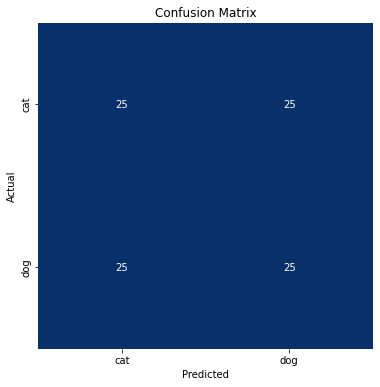

In [17]:
#Importation des modules:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

#Si la probabilité dépasse 0.5, la prédiction renvoie "cat":
predictions = (model.predict(test_generator) >= 0.5).astype(np.int)

#On génère la matrice de confusion fournissant une comparaison de la classes prédite et la classe actuelle:
cm = confusion_matrix(test_generator.labels, predictions, labels=[0, 1])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["cat", "dog"])
plt.yticks(ticks=[0.5, 1.5], labels=["cat", "dog"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
#Rapport de classification:
clr = classification_report(test_generator.labels, predictions, labels=[0, 1], target_names=["cat", "dog"])
print(clr)

              precision    recall  f1-score   support

         cat       0.50      0.50      0.50        50
         dog       0.50      0.50      0.50        50

    accuracy                           0.50       100
   macro avg       0.50      0.50      0.50       100
weighted avg       0.50      0.50      0.50       100



In [19]:
#On crée un répértoire de travail où on va enregistrer notre modèle
os.makedirs("./Saved_Models")

#Ensuite, on enregistre le modèle 
from keras.models import load_model
model.save('./Saved_Models/model_cat_dog.h5')

In [20]:
#On observe l'évolution des valeurs de perte et de précision selon les époques :
history_df = pd.DataFrame(history.history)
print(history_df)

        loss  accuracy  val_loss  val_accuracy       lr
0   0.816701   0.57855  0.689571        0.6012  0.00100
1   0.616766   0.68135  0.552113        0.7452  0.00100
2   0.537518   0.74815  0.496956        0.7784  0.00100
3   0.487730   0.78640  0.458912        0.8038  0.00100
4   0.429783   0.82185  0.416475        0.8232  0.00100
5   0.382459   0.84755  0.349840        0.8620  0.00100
6   0.331423   0.87255  0.363800        0.8524  0.00100
7   0.307186   0.88735  0.315437        0.8788  0.00100
8   0.277432   0.89590  0.280174        0.8930  0.00100
9   0.258623   0.90470  0.286107        0.8898  0.00100
10  0.229829   0.92180  0.300432        0.8928  0.00100
11  0.217212   0.92645  0.287747        0.8930  0.00100
12  0.145031   0.95665  0.248331        0.9140  0.00010
13  0.124570   0.96465  0.251609        0.9110  0.00010
14  0.116196   0.96630  0.241357        0.9120  0.00010
15  0.109032   0.96975  0.248815        0.9160  0.00010
16  0.104586   0.96910  0.248106        0.9160  

Minimum validation loss: 0.24135653674602509


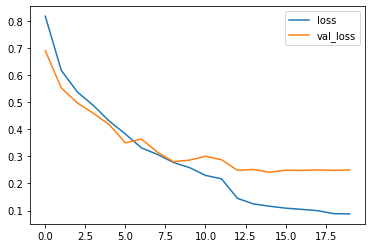

In [21]:
#Le graphique de la fonction de perte:
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Maximum validation accuracy : 0.9164000153541565


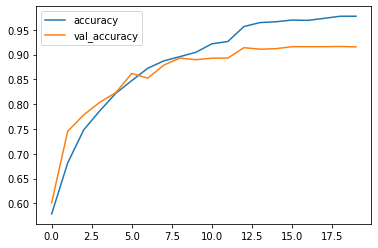

In [22]:
#Le graphique de la fonction de précision:
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Maximum validation accuracy : {}".format(history_df['val_accuracy'].max()))